In [1]:
import numpy as np
import seaborn as sns
import scipy as sp
import functools
%pylab inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from scipy.stats import multivariate_normal
import scipy.stats as stats
import time

Populating the interactive namespace from numpy and matplotlib


- $ m(x) = E[f(x)],
k(x, x
0
) = E[(f(x) − m(x))(f(x
0
) − m(x
0
))],$
- $
 f(x) ∼ GP
m(x), k(x, x
0
)
$
. 

In [29]:
function_one = lambda x: x**2
function_two = lambda x: np.log(x)**2

In [30]:
sp.integrate.quad(function_one,1,100)


(333333.0, 3.700739714673773e-09)

In [31]:
first = sp.integrate.quad(function_one,1,100)[0]
second = sp.integrate.quad(function_one,1,100)[1]
function_one_pdf = lambda x: function_one(x) / (first - second)

In [32]:
function_two_pdf = lambda x: function_two(x) / sp.integrate.simps(function_two(range(1,100)),range(1,100))

In [33]:
sp.integrate.simps(function_two_pdf(range(1,100)) ,range(1,100)) # this is a pdf!

1.0

In [34]:
sum([function_one_pdf(i) for i in range(1,100)])# this is a pdf!

0.98505098505099598

In [9]:
mean_function = lambda x: function_one_pdf(x)*function_one(x)+function_two_pdf(x)*function_two(x)
mean_function(2)

0.00021568770285579944

In [386]:
covariance_function = lambda x,x_: function_one_pdf(x)*(function_one(x) - mean_function(x) )* \
                        function_two_pdf(x_)*(function_two(x_)-mean_function(x_))

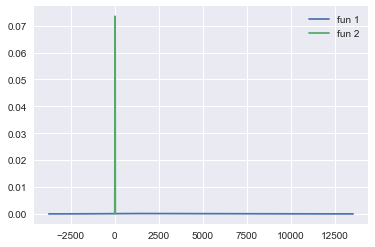

In [387]:
sns.kdeplot(np.array([function_one(i) for i in range(1,100)]),label='fun 1')
sns.kdeplot(function_two(range(1,100)) , label='fun 2')
plt.legend()

In [388]:
covariance_function(2.4,2)

1.6681421473598714e-08

In [389]:
# normal distribution to combine our model parameters
gp = lambda x,x_ : (mean_function(x),covariance_function(x,x_))

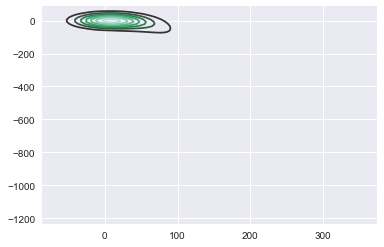

In [390]:
sns.kdeplot(np.array([gp(i,i) for i in range(1,100)]))

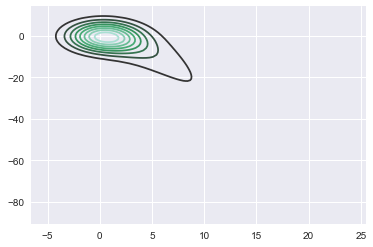

In [391]:
sns.kdeplot(np.array([gp(i,x) for i,x in zip(range(1,100),range(50,100))]))

# Gaussian  Normal Distirbution

- $ cov
f(xp), f(xq)

= k(xp, xq) = exp
−
1
2
|xp − xq|
2

. $
- $f∗ ∼ N
0, K(X∗, X∗)

, $

In [280]:
cov_normal = lambda x,x_ : np.exp(-.5*abs(x - x_)**2)

In [288]:
gaussian_vector = lambda x,x_ : sp.stats.norm(0,cov_normal(x,x_)).rvs()

(-5, 5)

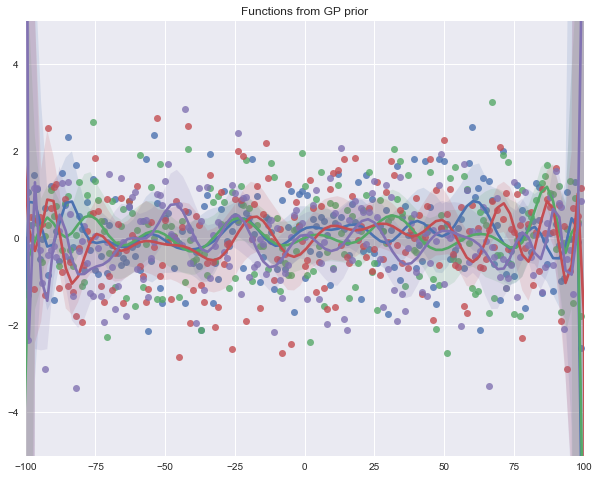

In [399]:

plt.figure(figsize=(10,8))
plt.title('Functions from GP prior')
sns.regplot(np.array(range(-100,100)),np.array([gaussian_vector(i,i) for i in range(-100,100)]),order=32)
sns.regplot(np.array(range(-100,100)),np.array([gaussian_vector(i,i) for i in range(-100,100)]),order=25)
sns.regplot(np.array(range(-100,100)),np.array([gaussian_vector(i,i) for i in range(-100,100)]),order = 27)
sns.regplot(np.array(range(-100,100)),np.array([gaussian_vector(i,i) for i in range(-100,100)]), order = 31)
plt.xlim(-100,100)
plt.ylim(-5,5)

## Noise free predictive distribution

$f∗|X∗, X,f ∼ N
K(X∗, X)K(X, X)
−1
f,
K(X∗, X∗) − K(X∗, X)K(X, X)
−1K(X, X∗)
$

Squarred Exponential =

- $exp
−
1
2
|xp − xq|
2

.$

In [640]:
squarred_exp_cv = lambda x_train,x_test : np.exp(-.5*abs(x_train - x_test)**2)

In [641]:
training = range(-100,100)
test = range(-200,100)
cov_training_training  = np.array([[cov_normal(x_,x_) for x_ in range(-100,100)] for _ in range(-100,100)])
cov_training_test = np.array([[cov_normal(x_,x) for (x_,x) in zip(range(-100,100),range(-200,100))]
                              for _ in range(-100,100)])

# Noisy predictive distribution
- training points = (-100,100)
- test points = (-200,300,400) # only two

In [517]:
training_funcion  =  lambda x: x/4

In [827]:
train_x = np.linspace(-500,100,300) # x values
test_x = np.linspace(-10,99,20)
train_y = np.array(list(map(training_funcion,train_x))).reshape(-1,1) # columns vector
train_y_var = np.var(train_y)

In [828]:
list(test_x)

[-10.0,
 -4.2631578947368425,
 1.473684210526315,
 7.2105263157894726,
 12.94736842105263,
 18.684210526315788,
 24.421052631578945,
 30.157894736842103,
 35.89473684210526,
 41.631578947368418,
 47.368421052631575,
 53.105263157894733,
 58.84210526315789,
 64.578947368421041,
 70.315789473684205,
 76.05263157894737,
 81.78947368421052,
 87.526315789473671,
 93.263157894736835,
 99.0]

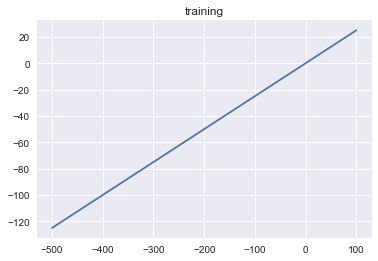

In [829]:
plt.plot(train_x,train_y)
plt.title('training');

In [830]:
train_y_var

1887.5418060200668

In [831]:

#squarred exponential covariance kernel
squarred_exponential_kernel = lambda x_,x: np.exp(-.5*(x_ - x)**2)


In [832]:
# find the covariance between the data points
cov_test_train_matrix = np.zeros((len(test_x),len(train_x)))
cov_test_test_matrix = np.zeros((len(test_x),len(test_x)))
cov_train_test_matrix = np.zeros((len(train_x),len(test_x)))
cov_train_train_matrix = np.zeros((len(train_x),len(train_x))) # assume noisy prediction
                                 

for idx_test, x_test in enumerate(test_x):
    for idx_train, x_train in enumerate(train_x):
        cov_test_train_matrix[idx_test,idx_train] = squarred_exponential_kernel(x_test,x_train)

for idx_test1, x_test1 in enumerate(test_x):
    for idx_test2, x_test2 in enumerate(test_x):
        cov_test_test_matrix[idx_test1,idx_test2]= squarred_exponential_kernel(x_test1,x_test2)
                                 
for idx_train, x_train in enumerate(train_x):
    for idx_test, x_test in enumerate(test_x):
        cov_train_test_matrix[idx_train,idx_test] = squarred_exponential_kernel(x_train,x_test)

for idx_train1, x_train1 in enumerate(train_x):
    for idx_train2, x_train2 in enumerate(train_x):
        cov_train_train_matrix[idx_train1,idx_train2] = squarred_exponential_kernel(x_train1,x_train2)
        
 

In [833]:
 # assume noisy predictions so teh covariance between the training points (train,train) has
# to add the variance of the y values
training_y_cov_matrix = np.zeros((len(cov_train_train_matrix),len(cov_train_train_matrix)), int)
np.fill_diagonal(training_y_cov_matrix, train_y_var)

In [834]:
cov_train_train_matrix = cov_train_train_matrix  + training_y_cov_matrix 

In [835]:
expected_mean_noisy_predictions = cov_test_train_matrix @ np.linalg.inv(cov_train_train_matrix) @train_y 

In [836]:
expected_mean_noisy_predictions  # test points,  predicted means

array([[-0.00167084],
       [-0.00071718],
       [ 0.00025115],
       [ 0.00120127],
       [ 0.00212311],
       [ 0.00304346],
       [ 0.00400115],
       [ 0.00500526],
       [ 0.00601691],
       [ 0.00697653],
       [ 0.00785747],
       [ 0.00869936],
       [ 0.00958654],
       [ 0.01058178],
       [ 0.01166724],
       [ 0.01274557],
       [ 0.01370913],
       [ 0.01452828],
       [ 0.015287  ],
       [ 0.01598296]])

In [837]:
test_x

array([-10.        ,  -4.26315789,   1.47368421,   7.21052632,
        12.94736842,  18.68421053,  24.42105263,  30.15789474,
        35.89473684,  41.63157895,  47.36842105,  53.10526316,
        58.84210526,  64.57894737,  70.31578947,  76.05263158,
        81.78947368,  87.52631579,  93.26315789,  99.        ])

In [838]:
expected_cov_noisy_predictions = cov_test_test_matrix - cov_test_train_matrix @ np.linalg.inv(cov_train_train_matrix)\
                    @ cov_train_test_matrix

In [839]:
expected_cov_noisy_predictions 

array([[  9.99499413e-001,  -3.60707238e-008,   7.86504468e-017,
         -5.15134731e-028,  -2.91415662e-036,   1.87762374e-046,
          1.02682962e-055,  -1.70319300e-065,  -4.11947444e-075,
          9.12557027e-085,   1.49613620e-094,  -3.91486962e-104,
         -3.27262773e-114,   1.82511162e-123,   2.50369655e-135,
         -8.98954200e-143,   2.74379175e-153,   3.69846602e-162,
         -2.20024988e-172,  -1.22776682e-181],
       [ -3.60707238e-008,   9.99454295e-001,  -3.11993651e-008,
          7.69513909e-017,  -1.38551157e-027,  -2.73281573e-036,
          2.77597656e-046,   1.05526401e-055,  -1.93786500e-065,
         -4.29064505e-075,   9.02252488e-085,   1.31238418e-094,
         -4.01961701e-104,  -2.03985061e-114,   2.02809226e-123,
         -1.50649332e-134,  -9.40413495e-143,   2.79690327e-153,
          3.46266838e-162,  -2.86829236e-172],
       [  7.86504468e-017,  -3.11993651e-008,   9.99466599e-001,
         -4.20315855e-008,   6.85806383e-017,  -2.87759630e-0

In [840]:
expected_cov_noisy_predictions.shape # NXN for the test points

(20, 20)

### Now, define a normal distribution given the parameters above

In [841]:
predictive_normal_noisy = sp.stats.multivariate_normal(expected_mean_noisy_predictions.ravel(),
                                                       expected_cov_noisy_predictions  )

In [842]:
predictive_normal_noisy.rvs()

array([ 0.11631433,  0.63064788, -0.14584552,  0.05949357, -1.9149441 ,
        0.48986877, -0.16532072,  0.46508993,  0.11344726, -0.6033401 ,
        1.0326625 , -1.96165292, -1.24253234, -0.19303591,  0.29424613,
       -0.28887835, -1.31724066,  1.15679366,  0.76111333, -1.07773477])

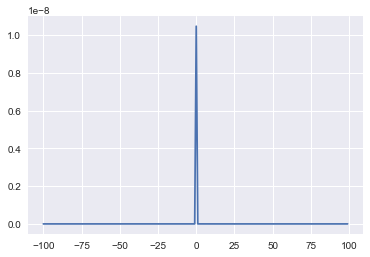

In [843]:
plt.plot(range(-100,100),[predictive_normal_noisy.pdf(i) for i in range(-100,100)])

In [844]:
predictive_normal_noisy.rvs(range_)

array([ 1.85273482, -1.29383106, -1.10035843,  0.96259757, -1.90368937,
       -1.7980305 , -2.67960172,  0.16163663,  1.48228845,  1.12602373,
        0.55455149,  0.60640082, -1.17230058,  0.11380901, -0.58935768,
       -1.15488053,  1.35193244,  0.51629356,  0.70305001, -1.59059142])

In [845]:
test_x

array([-10.        ,  -4.26315789,   1.47368421,   7.21052632,
        12.94736842,  18.68421053,  24.42105263,  30.15789474,
        35.89473684,  41.63157895,  47.36842105,  53.10526316,
        58.84210526,  64.57894737,  70.31578947,  76.05263158,
        81.78947368,  87.52631579,  93.26315789,  99.        ])

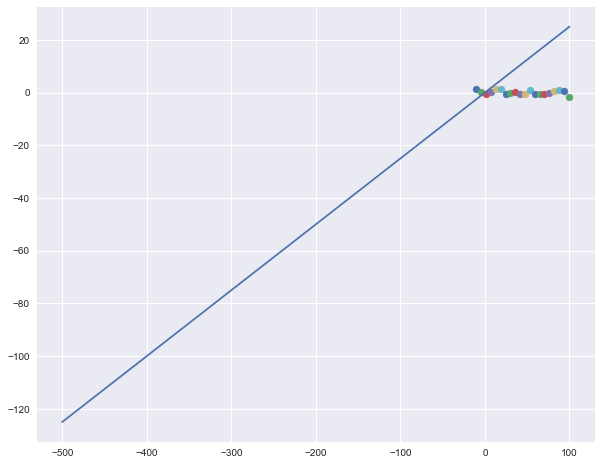

In [846]:
plt.figure(figsize=(10,8))
range_ = 1
predicted_points = predictive_normal_noisy.rvs(range_).T
#plt.scatter(test_x[0] ,predicted_points[0])

[plt.scatter(test_x[i],predicted_points[i]) for i in range(len(test_x))]
#plt.scatter(test_x[2],predicted_points[2])
#3plt.scatter(test_x[3],predicted_points[3])
plt.plot(train_x,train_y)
#plt.scatter(test_x[0],training_funcion(test_x[0]),label='X');#

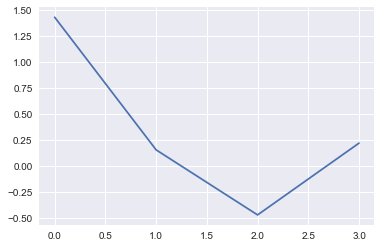

In [847]:
plt.plot([np.mean(predicted_points[0]), np.mean(predicted_points[1]), np.mean(predicted_points[2]),
         np.mean(predicted_points[3])])

In [ ]:
np.random.multivariate_normal()

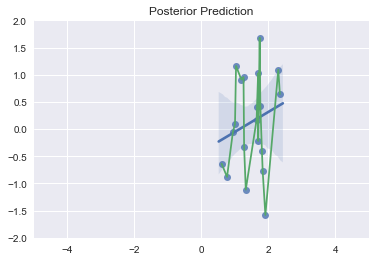

In [549]:
# random draws from the distrbution's posterior predictive
predicted_points = predictive_normal_noisy.rvs(20).T
predicted_points = np.array(sorted(predicted_points.T, key=lambda x: x[0])).T # sort the points
sns.regplot(*predicted_points,order=1)

#sns.regplot(*predicted_points,order=2)
plt.plot(*np.array(sorted(predicted_points.T, key=lambda x: x[0])).T) # plot them in order of smallest to largest
plt.xlim(-5,5)
plt.ylim(-2,2);
plt.title('Posterior Prediction')

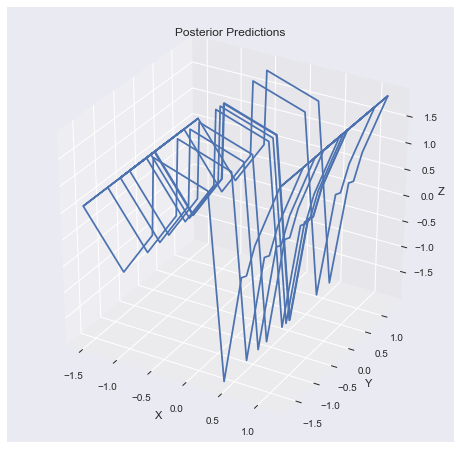

In [469]:


predicted_points = predictive_normal_noisy.rvs(10).T
predicted_points = np.array(sorted(predicted_points.T, key=lambda x: x[0])).T # sort the points

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')

#t = np.linspace(-3, 2, 31)
#s = np.linspace(-3, 2, 31)
x = predicted_points[0]
y = predicted_points[1]
z = predicted_points[2]

X, Y = np.meshgrid(x,y)
Z  = np.meshgrid(z,y)

ax.plot_wireframe(X,Y,Z[0],ccount=1, rcount=10)
#ax.plot_wireframe(X,Y,Z[1],ccount=1)
#ax.plot_surface(x,y,z, cmap=cm.jet, rstride=1, cstride=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_title('Posterior Predictions')

plt.show()

In [1708]:


x, y = np.mgrid[-5.0:5.0:50j, -5.0:5.0:50j]

# Need an (N, 2) array of (x, y) pairs.
xy = np.column_stack([x.flat, y.flat])
print(xy)
mu = np.array([0.0, 0.0])

sigma = np.array([.5, .5])
covariance = np.diag(sigma**2)

z =predictive_normal_noisy .pdf(xy)

# Reshape back to a (30, 30) grid.
z = z.reshape(x.shape)





fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(111, projection='3d')



ax.plot_surface(x,y,z)
#ax.plot_wireframe(x,y,z)
plt.title('PDF of multivariate gaussian process')
plt.show()

[[-5.         -5.        ]
 [-5.         -4.79591837]
 [-5.         -4.59183673]
 ..., 
 [ 5.          4.59183673]
 [ 5.          4.79591837]
 [ 5.          5.        ]]


ValueError: operands could not be broadcast together with shapes (2500,2) (20,) 

# Gaussian Regression with Cholesky Factorization

In [492]:
#squarred exponential covariance kernel
squarred_exponential_kernel = lambda x_,x: np.exp(-.5*abs(x_ - x)**2)

In [491]:
L = np.linalg.cholesky()

In [853]:

arr = numpy.array([1 for _ in range(10)])
mat = numpy.diag(arr)
mat

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

# New Attempt from Readings. Bayesian Gaussian Process Regression
- Gaussian Process for Regression: A Quick Introduction
    - M. Ebden

In [8]:
def squarred_kernel(a, b, param=2.0, train=False, train_noise = 5e-5):
    """Calculated the squarred exponential kernel. 
    Adds a noise term for the covariance of the training data
    Adjusting the param changes the difference where points will have a positive covariance
    Returns a covaraince Matrix"""
    if train == False:
        sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
        return np.exp(-.5 * (1/param) * sqdist)
    else:
        noisy_observations = train_noise*np.eye(len(a))
        sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T) 
        return np.exp(-.5 * (1/param) * sqdist) + noisy_observations 

In [9]:
from math import pi

In [10]:
test_x = np.array(np.linspace(-20,20,40)).reshape(-1,1)
train_x = np.array(np.linspace(-15,15,40)).reshape(-1,1)
train_y_func = lambda x: sin(x*1_000)*abs(x)
#train_y_func = lambda a,b : (a*b)/(a**2) - b
train_y_numbers = np.array([train_y_func(_) for _ in train_x]).reshape(-1,1)
y_var = np.var(train_y_numbers)
#max_covariance = np.sqrt(y_var) ## not sure a good number to choose for the noise of measuring your observations
max_covariance = 5


In [11]:
y_var

37.0055265323413

In [12]:
def test_gaussian_process(test_x, train_x, train_y_numbers, y_var, kernel, return_cov = False,
                          return_sample = False, covariance_noise = 5e-5, n_posteriors = 5):
    """Test one new point in the Gaussian process or an array of points
    Returns the mean, var from normal distribution from the sampled point.
    Return cov = True will return the full covariance matrix.
    
    If return_sample= True 
    returns samples from the informed posterior and the uninformed prior distribution
    
    Covariance noise is used to help enforce positive definite matrices
    
    N_posteriors indicates the number of posterior functions to create"""
    
    y_var = np.var(train_y_numbers)
    
    # define the covaraince functions
    covariance_train_train = kernel(train_x,train_x,train=True)
    
    covariance_test_train  = kernel(test_x,train_x)
    covariance_test_test  = kernel(test_x,test_x)

    # Use cholskey decomposition to increase speed for calculating mean
    try:
        L_test_test = np.linalg.cholesky(covariance_test_test + covariance_noise*np.eye(len(test_x)))
        L_train_train = np.linalg.cholesky(covariance_train_train + covariance_noise*np.eye(len(train_x)))
        Lk = np.linalg.solve(L_train_train, covariance_test_train.T)
        mus = np.dot(Lk.T, np.linalg.solve(L_train_train, train_y_numbers)).reshape((len(test_x),))
        # Compute the standard deviation so we can plot it
        s2 = np.diag(covariance_test_test) - np.sum(Lk**2, axis=0)
        stdv = np.sqrt(abs(s2))
        

    # Full matrix calculation of mean and covariance, much slower than cholesky decomposition
    except Exception as e:
        print(e)#LinAlgError: # In case the covaraince matrix is not positive definite 
        mus = covariance_test_train  @ np.linalg.pinv(covariance_train_train) @ train_y_numbers
        s2 = covariance_test_test - covariance_test_train @ np.linalg.pinv(covariance_train_train ) \
                     @ covariance_test_train.T
        
    

    def sample_from_posterior(n_priors=3, n_post=5):
        """Draw samples from the prior distribution of the GP.
        len(test_x) is the number of samplese to draw.
        Resource: http://katbailey.github.io/post/gaussian-processes-for-dummies/.
        
        N-Posteriors / N-Priors tells the number of functions to samples from the dsitribution"""

        
        # Draw samples from the posterior at our test points.
        L = np.linalg.cholesky(covariance_test_test +  covariance_noise*np.eye(len(test_x)) - np.dot(Lk.T, Lk))
        f_post = mus.reshape(-1,1) + np.dot(L, np.random.normal(size=(len(test_x),n_posteriors)))

        # Sample 3 sets of standard normals for our test points,
        # multiply them by the square root of the covariance matrix
        f_prior_uninformed = np.dot(L_test_test, np.random.normal(size=(len(test_x),n_priors)))
        # For the posterior, the columns are the vector for that function
        return (f_prior_uninformed, f_post)


    if return_cov == True:
        return y_pred_mean.ravel(), var_y_pred_diag.ravel(), var_y_pred
        
    if return_sample == True:
        f_prior, f_post = sample_from_posterior(n_post = n_posteriors)
        return mus.ravel(), s2.ravel(), f_prior, f_post
    else:
        return mus.ravel(), s2.ravel()
    
   

In [73]:
m,var, prior, post = test_gaussian_process(test_x, train_x, train_y_numbers, 
                                                   y_var,squarred_kernel, return_sample = True)

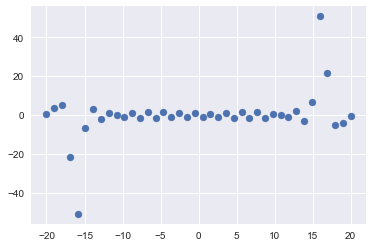

In [75]:
plt.scatter(test_x,m)

In [13]:

def sample_and_plot_posterior(test_x, train_y_func, test_gaussian_process,kernel, range_to_sample=np.linspace(-10,10,25)):
    """Plot potential posterior functions after sampling from the true function.
    Notice how the varaince decreases around the sampled points"""
    train_x = np.array(np.linspace(-20,20,1)).reshape(-1,1)
    train_y_numbers = np.array([train_y_func(_) for _ in train_x]).reshape(-1,1)
    for sampled_point in range_to_sample:
        print(f"Point Sampled x = {train_x.ravel()[-1]}")
        m,var, prior, post = test_gaussian_process(test_x, train_x, train_y_numbers, 
                                                   y_var,kernel, return_sample = True)
        plt.figure(figsize=(14,10))

        plt.gca().fill_between(test_x.flat, m-2*np.sqrt(var), m+2*np.sqrt(var), color="#dddddd",label='95% confidence')
        plt.scatter(train_x.ravel(), train_y_numbers,marker='*',label='Samples', linewidth=5, color='red')

        plt.plot(np.linspace(-20,20,400),[train_y_func(i) for i in np.linspace(-20,20,400)], label='real function',
                linestyle="--")
        plt.plot(test_x,post,color='black',label='Draws from the posterior');
        #plt.scatter(train_x,train_y_numbers)
        #plt.scatter(test_x,m,label='MU',color='red', linewidth=10, marker='*');
        plt.legend()
        plt.title('Posteriors, and Actual Function')
        plt.show();

        # Update training data with the sampled point
        train_x = train_x.ravel()
        train_x = np.append(train_x,sampled_point)
        train_x = train_x.reshape(-1,1)
        train_y_numbers = np.array([train_y_func(_) for _ in train_x]).reshape(-1,1)

        # sleep for three seconds
        time.sleep(1)

Point Sampled x = -20.0


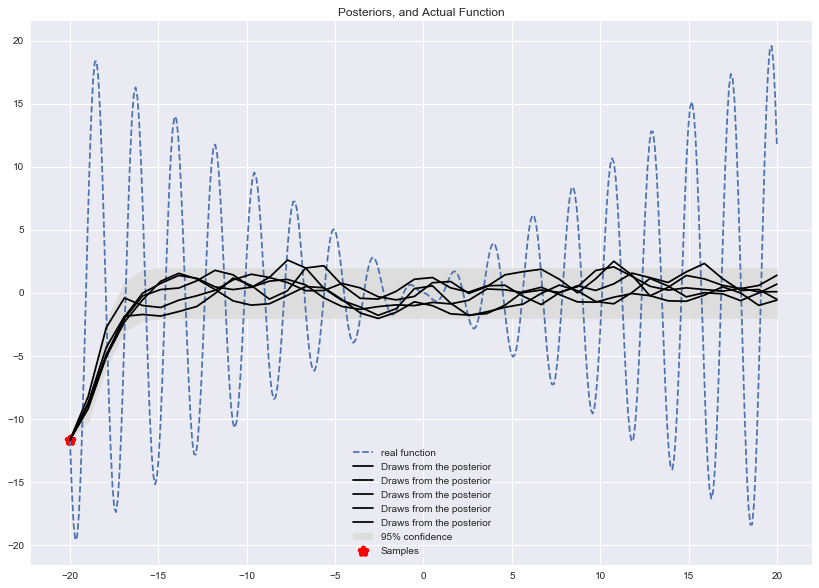

Point Sampled x = -10.0


KeyboardInterrupt: 

In [14]:
sample_and_plot_posterior(test_x, train_y_func, test_gaussian_process, squarred_kernel)

### Best estimate for Y* is given by the mean of the distribution


### Implement Expected Improvement


In [140]:
def expected_improvement(mean_x, sigma_squarred_x, y_val_for_best_hyperparameters, normal_dist=None, point_est = False):
    """Finds the expected improvement of a point give the current best point.
    If point_est = False, then computes the expected value on a vector from the posterior distribution.
    """
    from scipy.stats import norm
    
    with np.errstate(divide='ignore'): # in case sigma equals zero
        # Expected val for one point
        if point_est ==True:
            sigma_x = np.sqrt(sigma_squarred_x) # get the standard deviation from the variance

            Z = (mean_x - y_val_for_best_hyperparameters) / sigma_x

            if round(sigma_x,8) == 0:
                return 0
            else:
                return (mean_x - y_val_for_best_hyperparameters)*normal_dist.cdf(Z) + sigma_x*normal_dist.pdf(Z)

        else:
            # Sample from the posterior functions
            for _ in range(len(mean_x)):
                list_of_improvements = []
                for m,z,s in zip(mean_x, ((mean_x -y_val_for_best_hyperparameters)\
                                     / np.std(sigma_squarred_x)),np.sqrt(sigma_squarred_x) ):
                    
                    list_of_improvements.append(((m-y_val_for_best_hyperparameters)*norm(m,s).cdf(z)\
                                                 +s*norm(m,s).pdf(z)))
                    #print(m-y_val_for_best_hyperparameters,'top of Z')
                    
                    #print(norm(m,s).pdf(z),'norm(m,s).pdf(z)')
                    #print(z,'z')
                    #print(norm(m,s).cdf(z),'norm(m,s).cdf(z')
                    #print(m,'m')
                    #print(y_val_for_best_hyperparameters,'y_val_for_best_hyperparameters')
                    #print(s,'standard deviation BOTTOM OF Z')
                    #print()
                return list_of_improvements

In [141]:
def thompson_sampling():
    """Thompson sampling to find the`bb next point to pick"""

In [142]:
m,var, prior, post =  test_gaussian_process(test_x, train_x, train_y_numbers, 
                                                   y_var,squarred_kernel, return_sample = True)

In [143]:
squarred_kernel(m.reshape(-1,1),m.reshape(-1,1)).shape

(40, 40)

In [169]:
def sample_from_function( y_function, 
                        train_x, train_y_numbers, kernel, testing_domain = range(-500,500,10), n = 20,
                        adaption_n = .9999):
    """Sample N times from the unknown function and for each time find the 
    point that will have the highest expected improvement (find the maxima of the function).
    
    Returns a generator of x_sampled_points, y_sampled_points, sampled_variance, best_x, best_y,
    list_of_improvements and domain for improvements
    
    Starts off the search for expected improvement with a coarse search and then hones in on 
    the domain the the highest e xpected improvement.
    
    Adaption_n decreases the possible range of values to find a better number centered around the best x value"""
    start_point = np.random.randn()
    best_x = start_point
    best_y = y_function(start_point) # initial best y value based on start point
    start_y = y_function(start_point) 
    # for plotting the points sampled
    x_sampled_points = []
    y_sampled_points = []
    sampled_variance =[] 
    

    for i in range(n):
        if i == 0:
            
            s_p = np.array([testing_domain]).reshape(-1,1)
            
            
            # find the next x-point to sample
            mus, vars_,_,post = test_gaussian_process(s_p, train_x, train_y_numbers,
                                               np.var(s_p), kernel, return_sample = True, n_posteriors=30)
            
           
            
            sigmas_post = np.var(post,axis=1)
            mus_post = np.var(post,axis=1)
            # get the expected values from the posterior distribution
            list_of_expected_improvements = expected_improvement(mus_post, sigmas_post ,best_y)

            max_improv_x_idx = np.argmax(list_of_expected_improvements)
            max_improv_x = s_p[max_improv_x_idx]
  
            max_improv_y = y_function(max_improv_x  ) 
            if max_improv_y > best_y: ## use to find out where to search next
                best_y = max_improv_y 
                best_x = max_improv_x
            else:
                best_x = start_point
            

            sampled_variance.append(sigmas_post[max_improv_x_idx])

            # append the point to sample
            x_sampled_points.append(max_improv_x)
            y_sampled_points.append(max_improv_y)
            
            # append our new the newly sampled point to the training data
            train_x = np.vstack((train_x, max_improv_x))
            train_y_numbers = np.vstack((train_y_numbers, max_improv_y))
            yield x_sampled_points, y_sampled_points, sampled_variance, best_x, best_y, \
                list_of_expected_improvements,s_p
            

        else:
            # adaptive sampling
            testing_domain_l = abs(int(testing_domain[0]*adaption_n))
            #print(best_x - testing_domain_l, ' x - lower')
            
            testing_domain_h = abs(int(testing_domain[-1]*adaption_n))
            # shorted the testing domain to be around the best point
            testing_domain = range(int(testing_domain_l), int(testing_domain_h))
            testing_domain = np.linspace(testing_domain_l,testing_domain_h, num=2000).reshape(-1,1)
            #
            # find the next x-point to sample
            mus, vars_,_,post = test_gaussian_process(testing_domain, train_x, train_y_numbers,
                                               np.var(testing_domain), kernel, return_sample = True, n_posteriors=30)
            
            sigmas_post = np.var(post,axis=1)
            mus_post = np.var(post,axis=1)
            
            # get the expected values from the posterior distribution
            list_of_expected_improvements = expected_improvement(mus_post, sigmas_post, best_y)
            
            

            max_improv_x_idx = np.argmax(list_of_expected_improvements)
            max_improv_x = testing_domain[max_improv_x_idx]
  
            max_improv_y = y_function(max_improv_x  ) 
            if max_improv_y > best_y: ## use to find out where to search next
                best_y = max_improv_y 
                best_x = max_improv_x
            else:
                pass
            print(best_x,'best_x')

            sampled_variance.append(sigmas_post[max_improv_x_idx])

            # append the point to sample
            x_sampled_points.append(max_improv_x)
            y_sampled_points.append(max_improv_y)
            
            # append our new the newly sampled point to the training data
            train_x = np.vstack((train_x, max_improv_x))
            train_y_numbers = np.vstack((train_y_numbers, max_improv_y))
            
            yield x_sampled_points, y_sampled_points, sampled_variance, best_x, best_y, \
                list_of_expected_improvements, testing_domain
         


    

In [166]:
samples = 60

In [167]:
#x, y, variance_of_estimate, best_x,best_y = 
gen = sample_from_function(train_y_func,train_x, train_y_numbers,squarred_kernel, n=samples )

Point on x-axis just sampled =[-20]


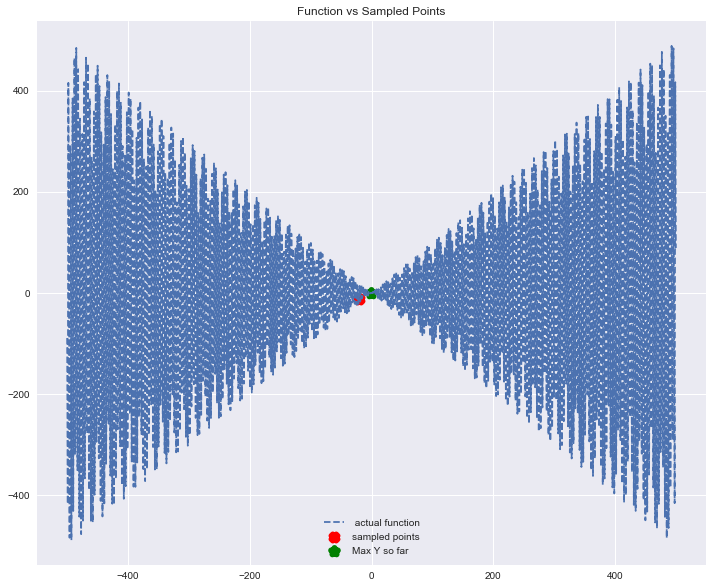

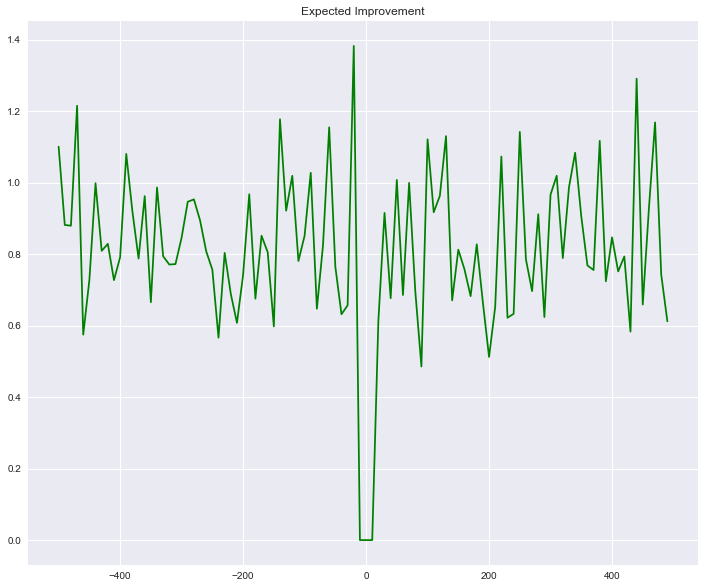

[-119.7444698] best_x
Point on x-axis just sampled =[-119.7444698]


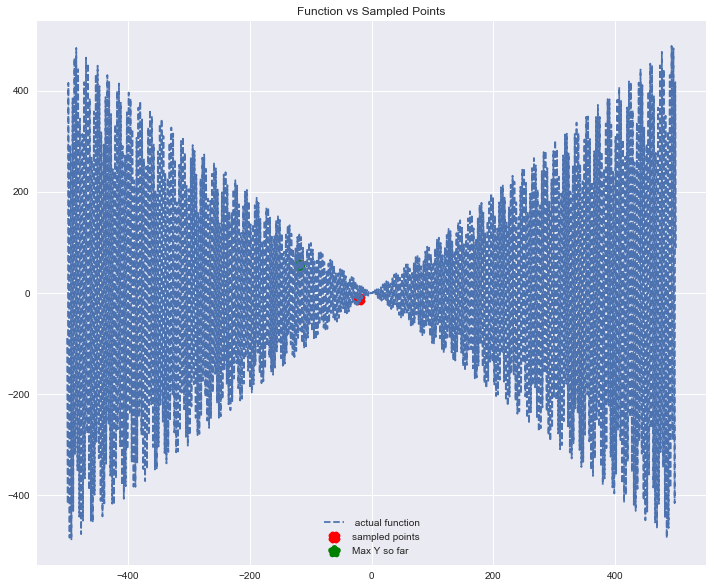

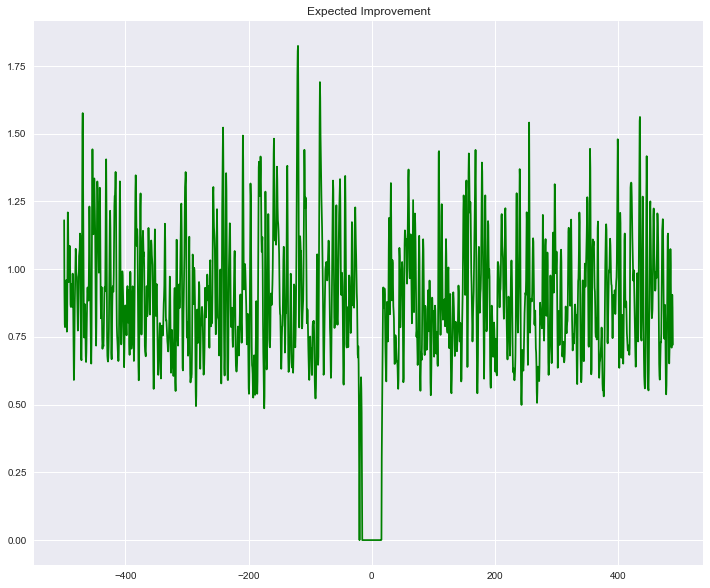

[-119.7444698] best_x
Point on x-axis just sampled =[-618.7444698]


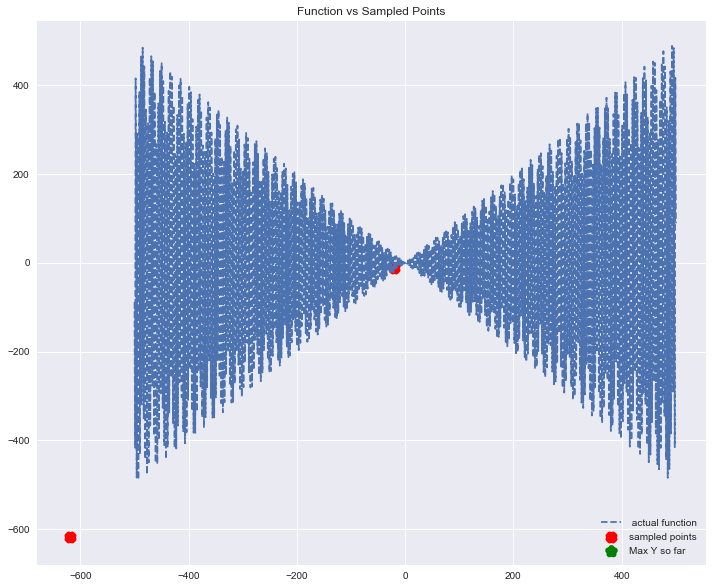

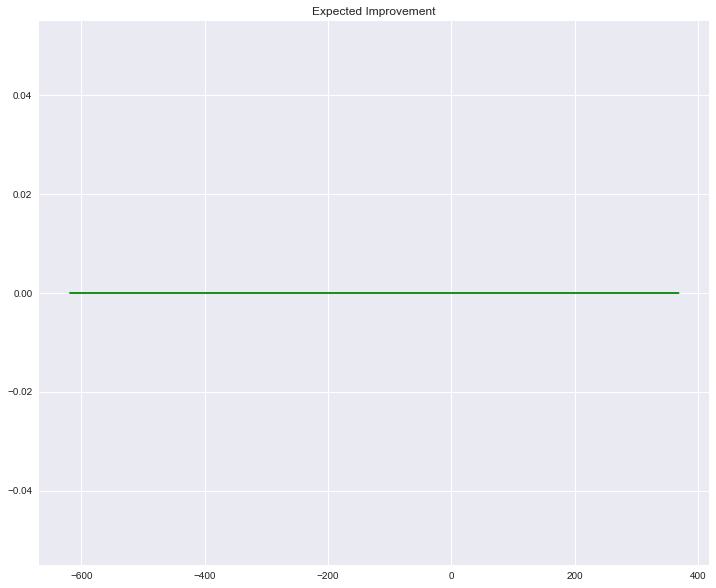

[-737.7444698] best_x
Point on x-axis just sampled =[-737.7444698]


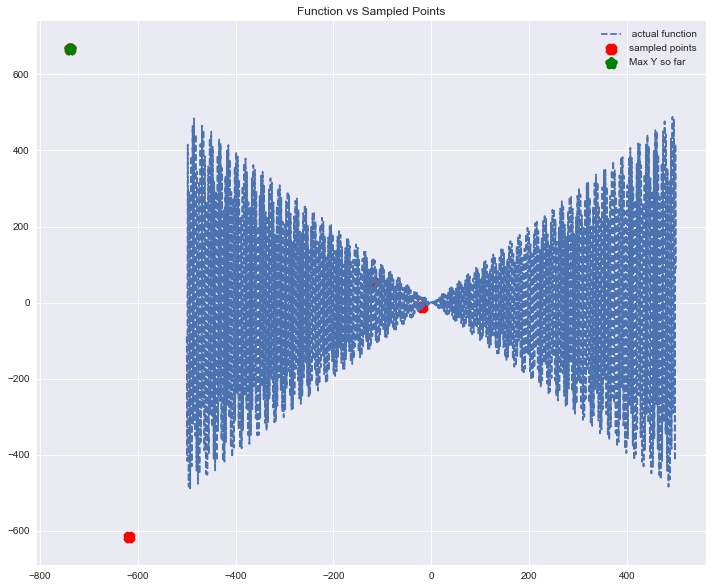

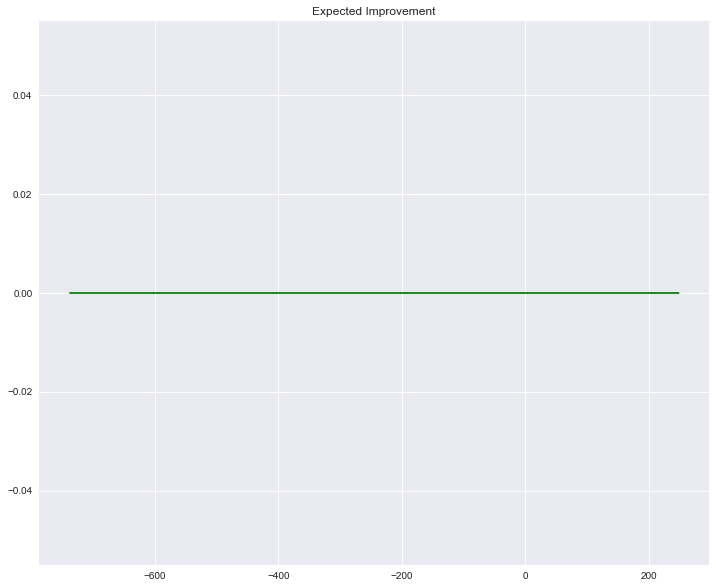

[-1474.7444698] best_x
Point on x-axis just sampled =[-1474.7444698]


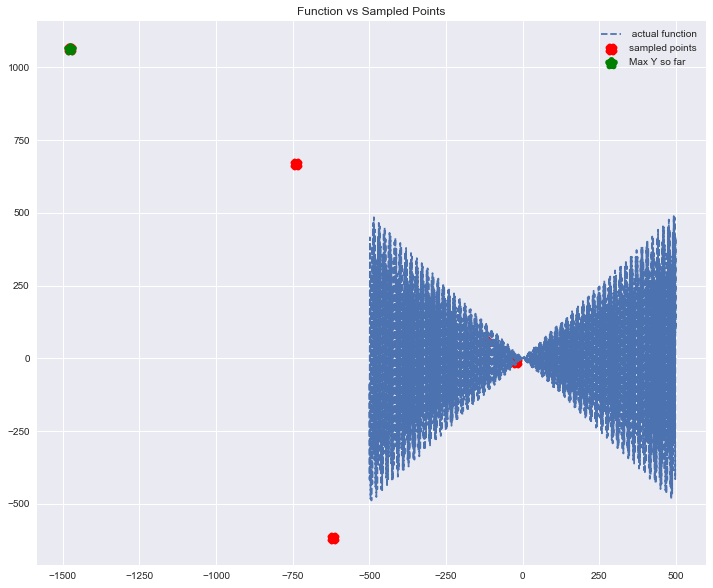

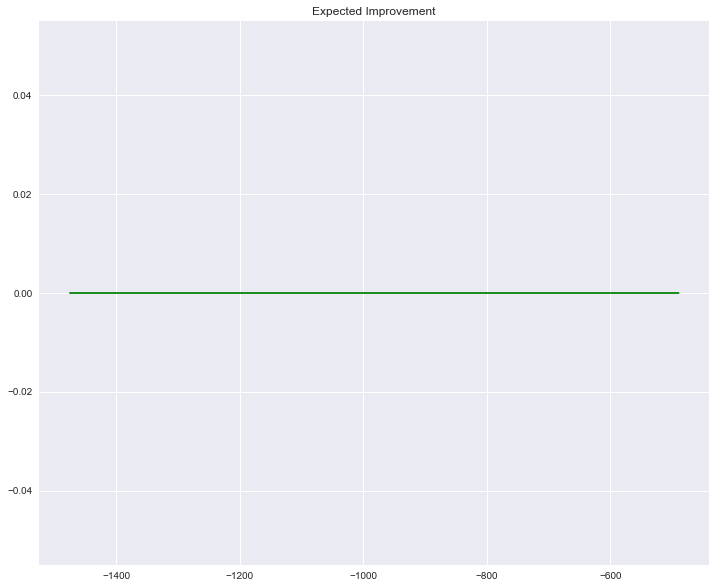

[-1474.7444698] best_x
Point on x-axis just sampled =[-2948.7444698]


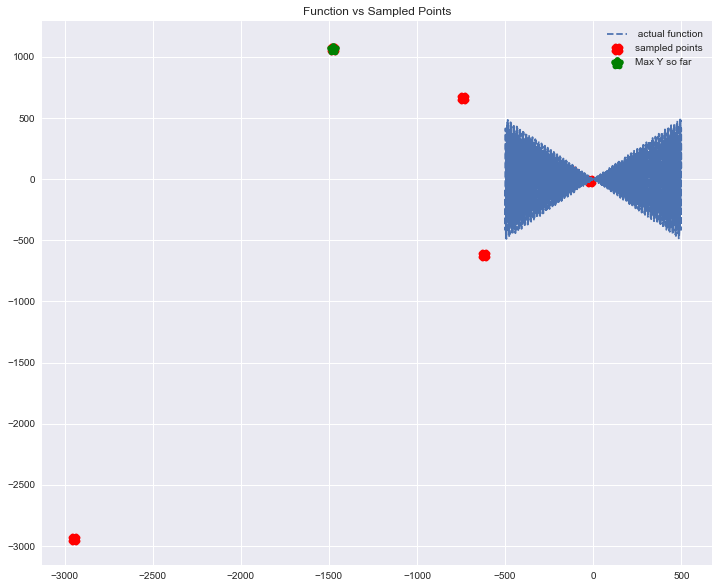

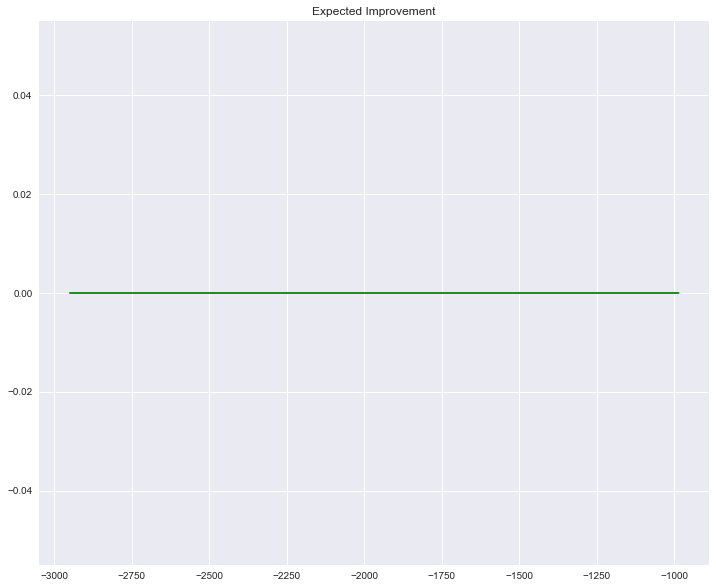

[-4422.7444698] best_x
Point on x-axis just sampled =[-4422.7444698]


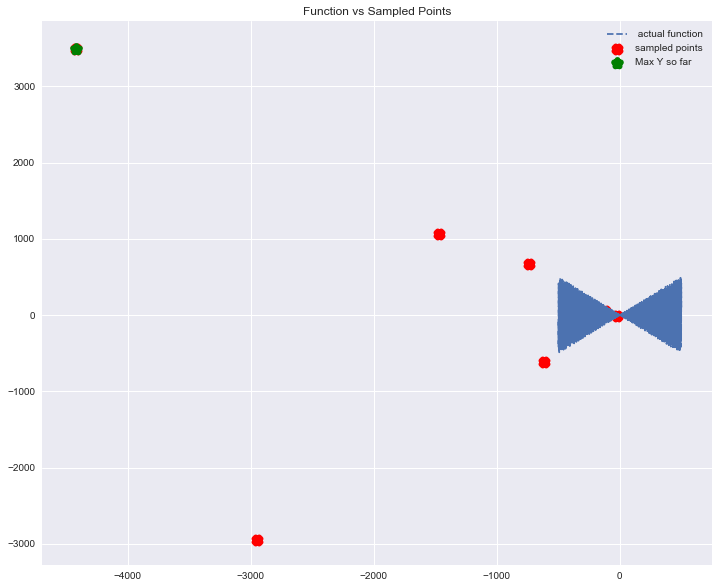

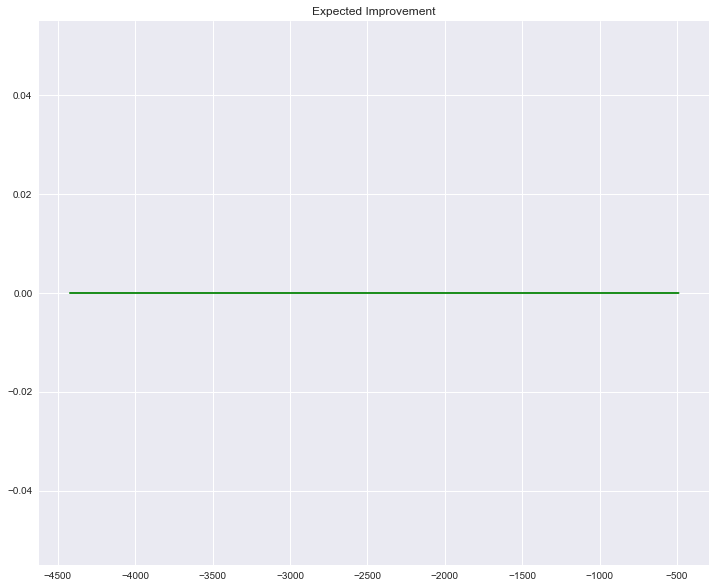

[-8844.7444698] best_x
Point on x-axis just sampled =[-8844.7444698]


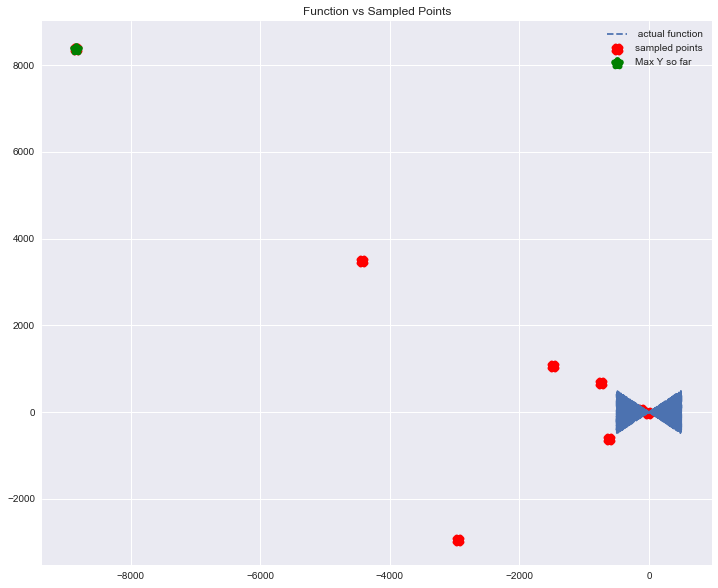

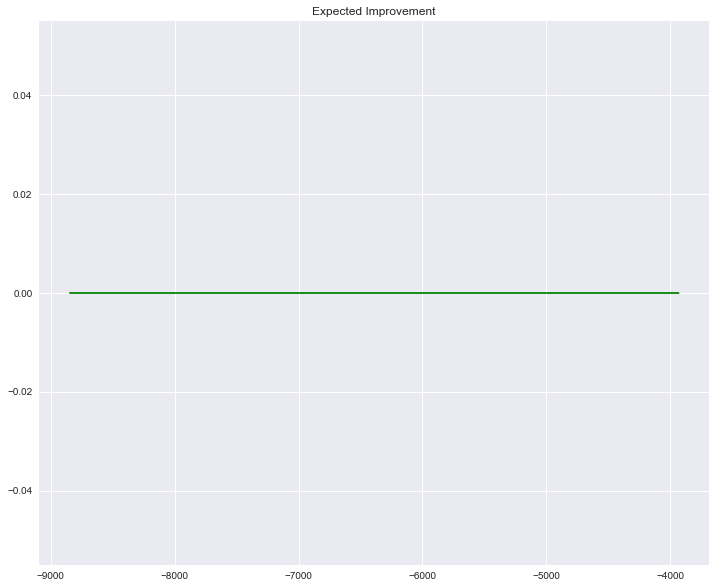

[-8844.7444698] best_x
Point on x-axis just sampled =[-17687.7444698]


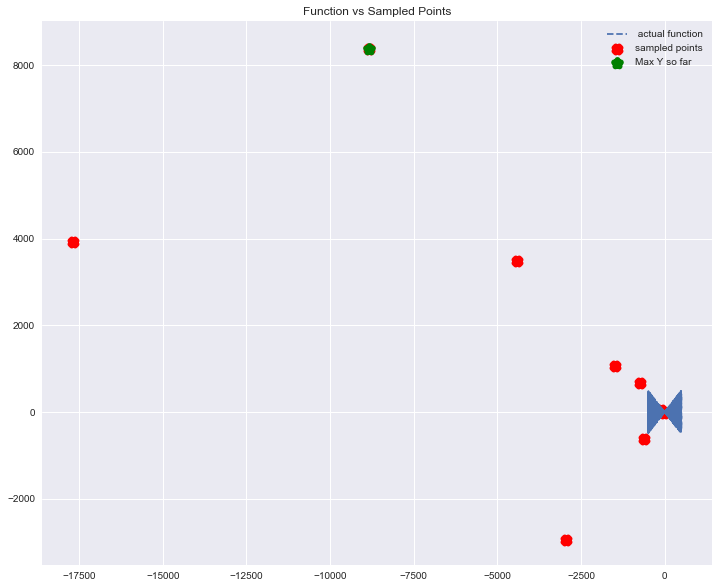

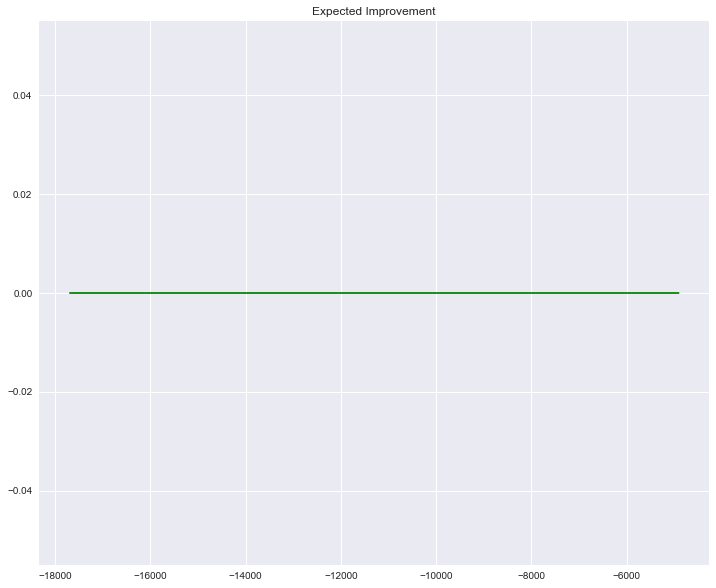

KeyboardInterrupt: 

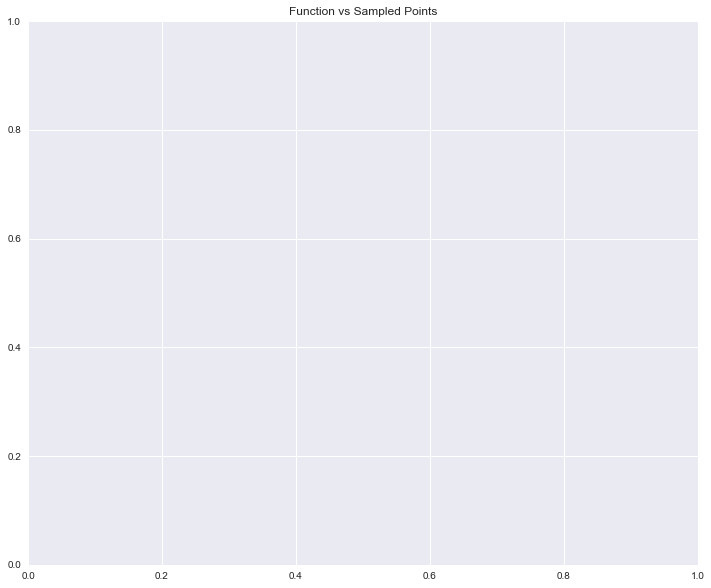

In [168]:


for i in range(samples):
    fig = plt.figure(figsize=(12,10))
    plt.title("Function vs Sampled Points")
    x_sampled_points, y_sampled_points, sampled_var, best_x, best_y, improvements, domain = next(gen)
     # Sizes for the axis
    train_y_x_axis = np.array(np.linspace(-500,500,1000))
    train_y_numbers_ = [train_y_func(i) for i  in train_y_x_axis]
    
    plt.plot(train_y_x_axis,train_y_numbers_, label=' actual function',linestyle="--")
    
    print(f"Point on x-axis just sampled ={x_sampled_points[-1]}")
    plt.scatter(x_sampled_points,y_sampled_points, color='red',marker='X',label='sampled points',linewidths=5)
    plt.scatter(best_x,best_y, marker = "*",label='Max Y so far',linewidths=6, color = 'green')
    #plt.gca().fill_between( np.array(x_sampled_points).flat, np.array(x_sampled_points)-2*np.sqrt(sampled_var),
    #                       np.array(x_sampled_points)+2*np.sqrt(sampled_var), color="#dddddd",label='95% confidence')
    
   
    
    

    plt.legend()
#     plt.ylim(-100,100)
    plt.show();
    fig = plt.figure(figsize=(12,10))
    plt.title('Expected Improvement')
    plt.plot(domain,improvements,label='Expected improvements',color='green')
    plt.show()

    
    # pause so we can see the graph
    #time.sleep(1);


In [ ]:
-3.95540428/0.554867603285 

In [125]:
-26/3.2

-8.125

In [ ]:
best_y = train_y_func(10)

In [171]:
best_y

8.9120736006143542

In [2389]:
np.array([_ for _ in range(-10,10)]) - best_y

array([-9.97279894, -8.97279894, -7.97279894, -6.97279894, -5.97279894,
       -4.97279894, -3.97279894, -2.97279894, -1.97279894, -0.97279894,
        0.02720106,  1.02720106,  2.02720106,  3.02720106,  4.02720106,
        5.02720106,  6.02720106,  7.02720106,  8.02720106,  9.02720106])

In [1707]:
expected_improvement(np.array([_ for _ in range(1500,2000)]), var_y_pred_diag[0], best_y  ,distribution) # new x-value

array([[ 750.34955314,  750.84955329,  751.34955344,  751.84955359,
         752.34955374,  752.84955389,  753.34955404,  753.84955418,
         754.34955433,  754.84955448,  755.34955463,  755.84955478,
         756.34955493,  756.84955508,  757.34955523,  757.84955538,
         758.34955553,  758.84955568,  759.34955583,  759.84955598,
         760.34955613,  760.84955628,  761.34955643,  761.84955658,
         762.34955673,  762.84955688,  763.34955703,  763.84955718,
         764.34955733,  764.84955748,  765.34955763,  765.84955778,
         766.34955794,  766.84955809,  767.34955824,  767.84955839,
         768.34955854,  768.84955869,  769.34955884,  769.849559  ,
         770.34955915,  770.8495593 ,  771.34955945,  771.8495596 ,
         772.34955976,  772.84955991,  773.34956006,  773.84956021,
         774.34956037,  774.84956052,  775.34956067,  775.84956083,
         776.34956098,  776.84956113,  777.34956129,  777.84956144,
         778.34956159,  778.84956175,  779.34956

In [1587]:
# test the y for the current expected improvements
if train_y_func(79.00479131) > best_y:
    best_y = train_y_func(79.00479131)
else:
    pass

In [1589]:
best_y # we found a better pint

1287.601446747913

In [1595]:
mu, sigma_squarred = test_gaussian_process(array([[ 79.00479131]]), train_x, train_y_numbers) # test this new point

In [1596]:
new_dist = stats.norm(mu,np.sqrt(sigma_squarred))

In [1597]:
distribution_new = stats.norm(mu, sigma ) # new distribution

In [1598]:
expected_improvement(mu, sigma, best_y, distribution_new )

array([ 46946.71930156])

In [1599]:
# sample another point

In [1602]:
# test the y for the current expected improvements
if train_y_func(46946.71930156) > best_y:
    best_y = train_y_func(46946.71930156)
else:
    pass

In [1604]:
best_y # we found a better point

1074068611.2654407

In [1605]:
mu, sigma_squarred = test_gaussian_process(array([[ 1074068611.2654407]]), train_x, train_y_numbers) # test this new point

In [1606]:
new_dist = stats.norm(mu,np.sqrt(sigma_squarred))

In [1607]:
distribution_new = stats.norm(mu, sigma ) # new distribution

In [1608]:
expected_improvement(mu, sigma, best_y, distribution_new )

array([ -5.36981876e+08])